In [1]:
import pandas as pd
import numpy as np
import glob
import random
import boto3
import io

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Connect to S3 bucket

In [2]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('chestxraylea')

In [3]:
labels_obj = bucket.Object('data/Data_Entry_2017_v2020.csv')
df_labels = pd.read_csv(io.StringIO(labels_obj.get()['Body'].read().decode('utf-8')))

train_obj = bucket.Object('data/train_val_list.txt')
train_id = pd.read_table(io.StringIO(train_obj.get()['Body'].read().decode('utf-8')), header=None)

test_obj = bucket.Object('data/test_list.txt')
test_id = pd.read_table(io.StringIO(test_obj.get()['Body'].read().decode('utf-8')), header=None)

In [4]:
files = [x.key for x in bucket.objects.filter()]
images = [x for x in files if 'png' in x]

In [5]:
images[:4]

['00001336_000.png',
 '00001337_000.png',
 '00001338_000.png',
 '00001338_001.png']

In [6]:
len(images)

107121

In [7]:
image_object = bucket.Object('00001336_000.png')
image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'png')

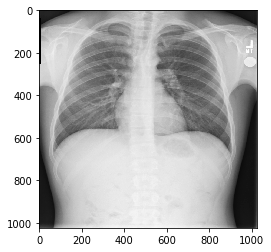

In [8]:
plt.imshow(image, cmap='gray')

In [9]:
image.shape

(1024, 1024)

In [10]:
def define_data(files, df_labels, train_id, test_id):
    df_files = pd.DataFrame({'image': images})
    
    train_id['set'] = 'train'
    train_id.columns = ['image', 'set']
    
    test_id['set'] = 'test'
    test_id.columns = ['image', 'set']
    
    train_val_test_ids = pd.concat([train_id, test_id])
    
    df = df_labels[['Image Index', 'Finding Labels']]
    df['label'] = [1 if 'Pneumonia' in x.split('|') else 0 for x in df['Finding Labels']]
    df = df.drop(columns=['Finding Labels'])
    df.columns = ['image', 'label']
    
    df = df.merge(train_val_test_ids, on='image', how='left')
    df = df.merge(df_files, on='image', how='right')
    df = df.dropna()
    
    return df

In [11]:
df = define_data(images, df_labels, train_id, test_id)
df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,image,label,set
0,00001336_000.png,0,train
1,00001337_000.png,0,train
2,00001338_000.png,0,train
3,00001338_001.png,0,train
4,00001338_002.png,0,train


In [12]:
df.shape

(107121, 3)

In [13]:
train = df[df.set=='train']
test = df[df.set=='test']

In [14]:
X = train['image']
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.iloc[0]

'00009679_000.png'

In [16]:
im_object = bucket.Object(X_train.iloc[0])
im = mpimg.imread(io.BytesIO(im_object.get()['Body'].read()), 'png')

In [17]:
im.shape

(1024, 1024)

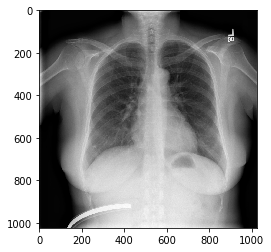

In [18]:
plt.imshow(im, cmap='gray')

# Dataset

In [19]:
def preprocessing_steps(im, shape=(224, 224)):
    """
    Pre-process image. Reshape to model input shape and normalize the data with Imagenet stats.
    """
    # Convert to RGB image
    im = np.resize(im, (im.shape[0], im.shape[1], 1))
    im = np.repeat(im.astype(np.uint8), 3, 2)
    # Resize to the given shape
    im = cv2.resize(im, shape)
    # Normalize the data with ImageNet stats
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    im =  (im - imagenet_stats[0])/imagenet_stats[1]
    return im

In [20]:
class ChestXRayDataset(Dataset):
 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        im_object = bucket.Object(self.x.iloc[idx])
        im = mpimg.imread(io.BytesIO(im_object.get()['Body'].read()), 'png')
        im = preprocessing_steps(im)
        # Horizontal Flip
        if np.random.random() > 0.5: 
            im = np.fliplr(im).copy()
        return np.rollaxis(im, 2), self.y.iloc[idx]

In [21]:
train_ds = ChestXRayDataset(X_train, y_train)
valid_ds = ChestXRayDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8)

In [22]:
x, y = next(iter(train_dl))

In [23]:
x.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

# Model

In [22]:
resnet = models.resnet18(pretrained=True)

In [23]:
layers = list(resnet.children())
print(len(layers))

10


In [24]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

# Learning rate finder

In [37]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [39]:
def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.4, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y.unsqueeze(1))
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    return lrs, losses

In [ ]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1)

In [ ]:
plt.plot(lrs, losses)
plt.show()